In [3]:
import os
import sys
import math
from liblibra_core import * 
from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma
from NumpyMIW import * #Calls below
import py3Dmol

#### Explicit function calls from NumpyMIW:
- MIW_Forces(X, params) : Used to compute MIW forces
- Write_Frame_To_XYZ(X, 1, filename) : Used in dyanmics for writing out trajectory to .xyz file.
- Populate1DUniform( number of worlds, spacing between the worlds)


### Set up the functions to compute potential/forces for a partcle in an D-dimensional harmonic potential.

$X =  [ [x_{00}, x_{01}, ...,  x_{0D}], [x_{10}, x_{11}, ...,  x_{1D}], ..., [x_{N0}, x_{N1}, ..., x_{ND}]]$

In [4]:
def Harmonic_Potential(X, xo, K):
    res = 0 
    for i in range(len(X)):
        for k in range(len(X[0])):
            res +=  .5 * K * (X[i][k] - xo)**2
    return(res)

# These two functions just compute harmonic potential/forces for something centered at xo along all DOFs
def Harmonic_Forces(X, xo, K):
    F = np.zeros(X.shape)
    for i in range(len(X)):
        for k in range(len(X[0])):
            F[i][k] = - K * ( X[i][k] - xo ) 
    return(F)

# Uses verlet for updates with both MIW and MM forces.
def VerletDynamics(X, V, params, method = 0, filename = 0):
    dt = params["dt"]
    steps = params["steps"]
    
    if method == 0:
        K = params["K"]
        xo = params["xo"]

        F, U = MIW_Forces(X, params)
        
        #Testing if sign is wrong
        #F = -F
        
        F += Harmonic_Forces(X, xo, K)
        for i in range(steps):
            X = X + V * dt + .5 * np.divide(F, M) * dt * dt
            V = V + .5 * np.divide(F, M) * dt
            F, U = MIW_Forces(X, params)
            
            #Testing if sign is wrong
            #F = -F
            
            F += Harmonic_Forces(X, xo, K)
            V = V + .5 * np.divide(F, M) * dt

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
# Very slow minimization algorithm, which is basically just the same as above with velocity reset to 0 each step.
# Swapping over to scipy optimization currently.
def MDMin(X, V, params, method = 0, filename = 0, conv_thr=1e-5):
    dt = params["dt"]
    steps = params["steps"]
    Flist = []
    if method == 0:
        K = params["K"]
        xo = params["xo"]

        F, U = MIW_Forces(X, params)
        F += Harmonic_Forces(X, xo, K)
        
        for i in range(steps):            
            X = X + .5 * np.divide(F, 1) * dt * dt
            F, U = MIW_Forces(X, params)            
            F += Harmonic_Forces(X, xo, K)
            Flist.append(max(abs(F[0])))

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
                
            if max(abs(F[0])) < conv_thr or i == list(range(steps))[-1]:
                if max(abs(F[0])) < conv_thr:
                    print("Force convergence reached, max force component < %f" % conv_thr)
                elif i == list(range(steps))[-1]:
                    print("Maximum number of steps reached, max force component not lower than %f" % conv_thr)
                finalPotential = U
                finalPotential += Harmonic_Potential(X, xo, K)
                
                return(Flist, finalPotential)
                
    return(Flist, finalPotential)

### Relevant Constants
$0.0367493 Ha = 1 eV$

$1.88973 Bohr = 1 A$

$1 eV/A = 0.0367493/1.88973 Ha/Bohr = 0.019446852195816332 Ha/Bohr$



#### Below sets up a 1D system of N worlds
- The system is then minimized (with a slow procedure which I'll swap to use a scipy opt algorithm)
- The max force at each iteration, and the final potential are the output.
- The next codeblock below plots the forces to get an idea of how long before all force components are ~1e-4/1e-5.

In [24]:
N = 10
spacing = .3
b = .5
D = 1
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)

M = np.zeros(X.shape)
m_p = 1836.0 # Mass of proton in au
M += m_p

eV_A2HaBohr = 0.019446852195816332

K1 = 1*eV_A2HaBohr

steps = 5000

params = {
    "J":1,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
    "K":K1,
    "xo":0,
    "dt":.1,
    "steps":steps
}
# file = "MDMin.xyz"
# os.system("rm %s" % file)
Flist, potential = MDMin(X, V, params)


Maximum number of steps reached, max force component not lower than 0.000010



# Equations being used to compare MIW ground state energy to HO Ground state energy.

----

## MIW:

$E_{tot} = U_{MW}(X) + U^{kernel}_{corr} + \Sigma_{worlds} \ V_{classical}$ Eq 15 Sturniolo
---------------------

----

## GS H.O.:

$E_o = \frac{1}{2}\hbar \omega$ with $\omega = \sqrt{\frac{k}{m}}$

Taking K = 1eV/A = $0.0194...$ Ha/Bohr

m for a Hydrogen ~ 1836 in a.u., we should have:

$\omega = \sqrt{\frac{k}{m}} = \sqrt{\frac{0.019446852195816332}{1836}} = 0.0032545302928249434$

So the ground state energy for a single HO in a.u. should be the factor below:

$E_o = .0016272651464124717 * N$ 
-----

----

## Error formulation

### From Fig 2 in Sturniolo, error is given as:


log$_{10}((E_{tot}-E_o)/(E_o))$
----

$E_{tot} \to$ MIW Energy

$E_o \to$ H.O. Energy. This is multiplied by N because MIW Energy grows with number of worlds.

----

### $U_{corr}$

The correction (Eq 14 Sturniolo) is 
$U_{corr}^{exp} = \frac{\hbar^2}{8m} \frac{D}{b^2}$, which I believe is per world, hence the factor of N where the correction is added in line 12 below.

I am not totally sure if the factor of N should be there, however I've tried both currently, and there is a larger source of error compared with the paper elsewhere, as this has little effect.


### Directly below takes the forces computed above, and plots max force vs iteration to get a feel for how many iterations are needed.
- I would add more things like average force for convergence, or change in MIW potential, but I am going to just switch to a better optimizer altogether.

Final force 0.008251516188117002
Potential after U_corr 0.33565823346354473
Log error = 1.2928569843201103
Potential 0.335658     |     Eo 0.016273


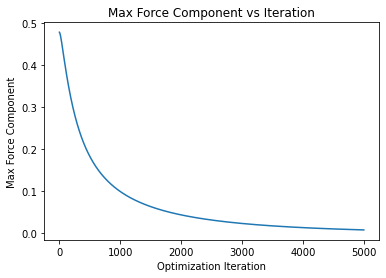

In [25]:
plt.figure(1)
plt.title("Max Force Component vs Iteration")
plt.ylabel("Max Force Component")
plt.xlabel("Optimization Iteration")
plt.plot(np.arange(len(Flist)), Flist)

Eo = .0016272651464124717

print("Final force", Flist[-1])


potential += ((N*D)/(8*M[0][0] * b**2 ))
print("Potential after U_corr", potential)

print("Log error =", np.log10( abs( potential - (Eo*N) )  / (Eo*N) ) )

print("Potential %f     |     Eo %f" % (potential, Eo*N) )

## Relative strength of MIW/Harmonic potentials

- This is just to give a rough idea in the N=2 case of at what scales the respective forces are most relevant.
- I was mainly using this to try some different values for k.

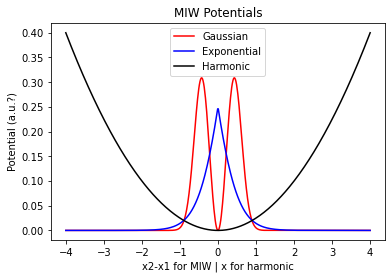

In [18]:
x1 = 0
start = -4
steps = 500
x2 = np.linspace(-start, start, steps)

b = .5
J = 1
D = 1
N = 2
X = np.zeros( ( N , J*D ) )
M = np.zeros( X.shape ) 
M += 1
params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


X = np.zeros( ( N , J*D ) )

X[0][0] = x1
GaussianPotentials = np.zeros( (len(x2), 1) )
ExponentialPotentials = np.zeros( (len(x2), 1) )
HarmonicPotentials = np.zeros( (len(x2), 1) )
                              
for i in range(len(x2)):
    X[1][0] = x2[i]
                              
    params["ktype"]="gaussian"
    F, U = MIW_Forces(X, params)
    GaussianPotentials[i] = U
                              
    params["ktype"]="exponential"
    F, U = MIW_Forces(X, params)
    ExponentialPotentials[i] = U
    
    HarmonicPotentials[i] = Harmonic_Potential(X, 0, .05)
                            

plt.figure(2)
plt.title("MIW Potentials")
plt.xlabel("x2-x1 for MIW | x for harmonic")
plt.ylabel("Potential (a.u.?)")
plt.plot(x2, GaussianPotentials, color = 'red', label = 'Gaussian')
plt.plot(x2, ExponentialPotentials, color ='blue', label = 'Exponential')
plt.plot(x2, HarmonicPotentials, color = 'black', label = 'Harmonic')
plt.legend();


## Dynamics in the harmonic potential.
- This also helps to visualize the trajectories
- Can just swap 'gaussian' and 'exponential' in params.

In [5]:
N = 2
spacing = 1
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1

params = {
    "J":1,
    "D":1,
    "b":.5,
    "ktype":"gaussian",
    "M":M,
    "K":1,
    "xo":0,
    "dt":.1,
    "steps":100
}

file = "HarmonicTraj.xyz"
os.system("rm %s" % file)
VerletDynamics(X, V, params, filename = file)

## MDMin in the harmonic potential.
- Aids in seeing the issue associated with the gaussian kernel, where the particles tend to clump up in optimization.
- Exponential kernel looks good, but I will add something to take X->P(X) for comparison with $|\psi_o|^2$ for H.O. Can use this to quantity

In [22]:
N = 10
spacing = .5
X = Populate1DUniform(N, spacing)

V = np.zeros(X.shape)
M = np.zeros(X.shape)
M += 1

params = {
    "J":1,
    "D":1,
    "b":.5,
    "ktype":"gaussian",
    "M":M,
    "K":1,
    "xo":0,
    "dt":.1,
    "steps":500
}
file = "MDMin.xyz"
os.system("rm %s" % file);
MDMin(X, V, params, filename = file);

Force convergence reached, max force component < 0.000010


### The attempt at recreating Figure 2
- Computes the Log error for N = 2 -> 80 every 2 worlds.
- Should follow the Solid Green Triangles in the Top Left Panel of Fig 2 in Sturniolo
- This is slow because the code is far from optimized, so the same plot is redone in the cell below. 
- - Just did this so that the block directly below could be modified to compare with N=2->N=78 plot.

Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 2
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 4
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 6
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 8
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 10
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 12
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 14
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 16
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 18
Maximum number of steps reached, max force component not lower than 0.000010
Finished N = 20
Maximum number of steps reached, max force component not lower than 0.0000

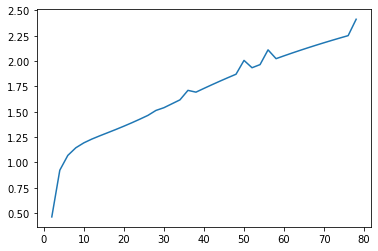

In [22]:
N = 10
spacing = .3
b = .5
D = 1

M = np.zeros(X.shape)
m_p = 1836.0 # Mass of proton in au
M += m_p

eV_A2HaBohr = 0.019446852195816332
K1 = 1*eV_A2HaBohr
steps = 2000
Eo = .0016272651464124717

params = {
    "J":1,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
    "K":K1,
    "xo":0,
    "dt":.1,
    "steps":steps
}

LogErr = []
Nworlds = []
Nmax = 80

# Loops through and computes the errors for N = 2 - > N = 80 worlds.
for i in range(1,Nmax):
    if i % 2 == 0:
        N = i
        X = Populate1DUniform(N, spacing)
        V = np.zeros(X.shape)

        M = np.zeros(X.shape)
        m_p = 1836.0 # Mass of proton in au
        M += m_p
        
        params["M"] = M

        Flist, potential = MDMin(X, V, params)
        err = np.log10( abs( potential - (Eo*N) )  / (Eo*N) )
        potential += ((N*D)/(8*M[0][0] * b**2 ))
        print("Finished N =", N)
        Nworlds.append(N)
        LogErr.append(err)



plt.plot(Nworlds, LogErr)
        
# print("Log error for N =", N,  np.log10( abs( potential - (Eo*N) )  / (Eo*N) ) )
# print("Potential %f     |     Eo %f" % (potential, Eo*N) )

Text(0, 0.5, 'log$_{10}[( E - Eo) / Eo]$')

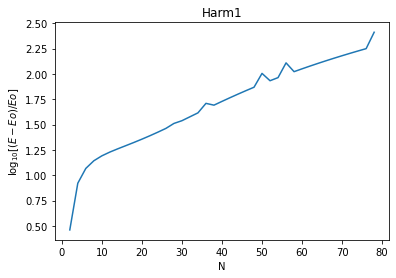

In [23]:
plt.plot(Nworlds, LogErr)
plt.title("Harm1")
plt.xlabel("N")
plt.ylabel("log$_{10}[( E - Eo) / Eo]$")